In [1]:
# !tar -xvzf dataset.tar.gzb
# !unzip dales_las.zip
# !unzip dales_tiled.zip

In [1]:
!pip uninstall torch torchvision torchaudio torch-scatter torch-sparse torch-cluster -y
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip3 install torch==2.2.1 torchvision==0.17.1 torchaudio==2.2.1 --index-url https://download.pytorch.org/whl/cu121
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html --no-cache-dir
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html --no-cache-dir
!pip install -q torch-cluster -f https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html --no-cache-dir
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install matplotlib pyvis torchmetrics
!pip install laspy


Found existing installation: torch 1.13.1+cpu
Uninstalling torch-1.13.1+cpu:
  Successfully uninstalled torch-1.13.1+cpu
Found existing installation: torch-scatter 2.1.0+pt113cpu
Uninstalling torch-scatter-2.1.0+pt113cpu:
  Successfully uninstalled torch-scatter-2.1.0+pt113cpu
Found existing installation: torch-sparse 0.6.16+pt113cpu
Uninstalling torch-sparse-0.6.16+pt113cpu:
  Successfully uninstalled torch-sparse-0.6.16+pt113cpu
Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.3/757.3 MB 1.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 41.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 15.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 55.6 MB/s eta 0:00:0000:01:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.9/170.9 kB 23.2 MB/s

In [2]:
!nvidia-smi

Thu May  2 14:28:19 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 4000     Off  | 00000000:00:05.0 Off |                  N/A |
| 30%   39C    P8     5W / 125W |      1MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from glob import glob
import os.path as osp
import os
import laspy as lp
import numpy as np
from tqdm.auto import tqdm


import torch
import torch.nn.functional as F
from torchmetrics.functional import jaccard_index

import torch_geometric.transforms as T
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from torch_geometric.nn import MLP, PointNetConv, fps, global_max_pool, radius,knn_interpolate
from torch_geometric.typing import WITH_TORCH_CLUSTER
from torch_geometric.utils import scatter

import matplotlib.pyplot as plt

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.2.1+cu121


In [4]:
if not WITH_TORCH_CLUSTER:
    quit("This example requires 'torch-cluster'")

# Define PointNet++ Segmentation model

In [5]:
class SAModule(torch.nn.Module):
    def __init__(self, ratio, r, nn):
        super().__init__()
        self.ratio = ratio
        self.r = r
        self.conv = PointNetConv(nn, add_self_loops=False)

    def forward(self, x, pos, batch):
        idx = fps(pos, batch, ratio=self.ratio)
        
        row, col = radius(pos, pos[idx], self.r, batch, batch[idx],
                          max_num_neighbors=64)
        edge_index = torch.stack([col, row], dim=0)
        x_dst = None if x is None else x[idx]
        
        # print(f"idx shape: {idx.shape}")
        # print(f"x shape: {x.shape}")
        # print(f"pos shape: {pos.shape}")
        # print(f"x_dst shape: {x_dst.shape}")
        # print(f"edge_index shape: {edge_index.shape}")
        
        x = self.conv((x, x_dst), (pos, pos[idx]), edge_index)
        pos, batch = pos[idx], batch[idx]
        return x, pos, batch


In [6]:
class GlobalSAModule(torch.nn.Module):
    def __init__(self, nn):
        super().__init__()
        self.nn = nn

    def forward(self, x, pos, batch):
        x = self.nn(torch.cat([x, pos], dim=1))
        x = global_max_pool(x, batch)
        pos = pos.new_zeros((x.size(0), 3))
        batch = torch.arange(x.size(0), device=batch.device)
        return x, pos, batch

In [7]:
class FPModule(torch.nn.Module):
    def __init__(self, k, nn):
        super().__init__()
        self.k = k
        self.nn = nn

    def forward(self, x, pos, batch, x_skip, pos_skip, batch_skip):
        x = knn_interpolate(x, pos, pos_skip, batch, batch_skip, k=self.k)
        if x_skip is not None:
            x = torch.cat([x, x_skip], dim=1)
        x = self.nn(x)
        return x, pos_skip, batch_skip

In [8]:
class Net(torch.nn.Module):
    def __init__(self, num_classes , num_features):
        super().__init__()
        
        self.num_classes = num_classes
        self.num_features = num_features

        # Input channels account for both `pos` and node features.
        # self.sa1_module = SAModule(0.2, 0.2, MLP([3 + 3, 64, 64, 128]))
        self.sa1_module = SAModule(0.2, 0.2, MLP([3 + num_features, 64, 64, 128]))
        # self.sa2_module = SAModule(0.25, 0.4, MLP([128 + 3, 128, 128, 256]))
        # self.sa1_module = SAModule(0.8, 0.2, MLP([3 + num_features, 64, 64, 128]))
        self.sa2_module = SAModule(0.25, 0.4, MLP([128 + 3, 128, 128, 256]))
        self.sa3_module = GlobalSAModule(MLP([256 + 3, 256, 512, 1024]))

        self.fp3_module = FPModule(1, MLP([1024 + 256, 256, 256]))
        self.fp2_module = FPModule(3, MLP([256 + 128, 256, 128]))
        self.fp1_module = FPModule(3, MLP([128 + num_features, 128, 128, 128]))

        # self.mlp = MLP([128, 128, 128, num_classes], dropout=0.5, norm=None)
        self.mlp = MLP([128, 128, 128, num_classes], dropout=0.2, norm=None)

        # self.lin1 = torch.nn.Linear(128, 128)
        # self.lin2 = torch.nn.Linear(128, 128)
        # self.lin3 = torch.nn.Linear(128, num_classes)

    def forward(self, data):
        sa0_out = (data.x, data.pos, data.batch)
        sa1_out = self.sa1_module(*sa0_out)
        sa2_out = self.sa2_module(*sa1_out)
        sa3_out = self.sa3_module(*sa2_out)

        fp3_out = self.fp3_module(*sa3_out, *sa2_out)
        fp2_out = self.fp2_module(*fp3_out, *sa1_out)
        x, _, _ = self.fp1_module(*fp2_out, *sa0_out)

        return self.mlp(x).log_softmax(dim=-1)

In [9]:
class DeepNet(torch.nn.Module):
    def __init__(self, num_classes , num_features, ratio = [0.5, 0.5, 0.5], r = [0.2, 0.2, 0.2],  act = 'relu'):
        super().__init__()
        self.num_classes = num_classes
        self.num_feature = num_features
        # Input channels account for both pos and node features.
        # self.sa1_module = SAModule(0.2, 0.2, MLP([3 + 3, 64, 64, 128]))
        self.sa1_module = SAModule(ratio[0], r[0], MLP([3 + num_features, 64, 64, 128], act = act ))
        self.sa2_module = SAModule(ratio[1], r[1], MLP([128 + 3, 128, 128, 256], act = act))
        self.sa3_module = SAModule(ratio[2], r[2], MLP([256 + 3, 256, 256, 512], act = act))
        self.sa4_module = GlobalSAModule(MLP([512 + 3, 512, 512, 1024], act = act))
        
        self.fp4_module = FPModule(1, MLP([1024 + 512, 512 , 512], act = act))
        self.fp3_module = FPModule(3, MLP([512 + 256, 256, 256], act = act))
        self.fp2_module = FPModule(3, MLP([256 + 128, 256, 256], act = act))
        self.fp1_module = FPModule(3, MLP([256 + num_features, 128, 128, 128], act = act))

        self.mlp = MLP([128, 128, 128, num_classes], act = "sigmoid", norm=None)

        # self.lin1 = torch.nn.Linear(128, 128)
        # self.lin2 = torch.nn.Linear(128, 128)
        # self.lin3 = torch.nn.Linear(128, num_classes)

    def forward(self, data):
        sa0_out = (data.x, data.pos, data.batch)
        sa1_out = self.sa1_module(*sa0_out)
        sa2_out = self.sa2_module(*sa1_out)
        sa3_out = self.sa3_module(*sa2_out)
        sa4_out = self.sa4_module(*sa3_out)
        
        fp4_out = self.fp4_module(*sa4_out, *sa3_out)
        fp3_out = self.fp3_module(*fp4_out, *sa2_out)
        fp2_out = self.fp2_module(*fp3_out, *sa1_out)
        x, _, _ = self.fp1_module(*fp2_out, *sa0_out)

        return self.mlp(x).log_softmax(dim=-1)

In [10]:
def create_model( sampling_ratio = [0.25, 0.25, 0.25 ], ball_radius = [0.2, 0.4, 0.4], act = 'relu', num_classes = 9, num_features = 1): 
    return DeepNet(ratio = sampling_ratio, 
                   r = ball_radius, 
                   num_classes = num_classes, 
                   num_features = num_features, 
                   act = act)

# Preprocessing data

In [12]:
#Get all las file for training 
TILES_SIZE = 15

TRAIN_DIR = f"dales_tiled/tiles_{TILES_SIZE}/train/" 
TEST_DIR = f"dales_tiled/tiles_{TILES_SIZE}/test/" 
all_test_files  = os.listdir(osp.abspath(TEST_DIR))

In [11]:
# pc = lp.read(os.path.join(TRAIN_DIR, all_train_files[0])) 
# for dimension in pc.point_format.dimensions:
#     print(dimension.name)

In [13]:
def convertData(laspath, debug = False, transform = True):
    
    pc = lp.read(laspath)
    
    # Define preprocessing steps
    transform = T.Compose([
        T.RandomJitter(0.01),
        T.RandomRotate(15, axis=0),
        T.RandomRotate(15, axis=1),
        T.RandomRotate(15, axis=2)
        ])
    pre_transform = T.NormalizeScale()
    
    # Get imformation from las file
    coords = np.vstack((pc.x, pc.y, pc.z)).transpose()    
    scales = pc.header.scales
    offsets= pc.header.offsets    
    
    labels = pc.classification.array
    features = pc.intensity if np.max(pc.intensity) > 0 else np.ones_like(pc.intensity, dtype = np.uint8)
    if len(features.shape) <2: 
        features = features[:, np.newaxis]
    num_classes = len(np.unique(labels))
    
    data = Data(x = torch.from_numpy(coords).type(torch.FloatTensor),  
                    pos = torch.from_numpy(coords).type(torch.FloatTensor), 
                    y = torch.from_numpy(labels), 
                    num_classes=num_classes,
                    num_features = coords.shape[-1],
                    # transform = transform, 
                    # pre_transform= pre_transform,
               batch = torch.from_numpy(np.zeros_like(features,dtype = np.int64)).flatten()
               )
    if transform: 
        return transform( pre_transform( data))
    else:
        return data

In [14]:
class BatchLoader(): 
    def __init__(self, pc, batch_size = 32000):
        self.data = convertData(pc) 
        self.batch_size = batch_size 
        self.num_points  = int(self.data.x.shape[0])
        self.num_batches =  self.num_points // self.batch_size
        self.num_classes = self.data.num_classes
        self.num_features = self.data.num_features
        
        self.transform = T.Compose([
        T.RandomJitter(0.01),
        T.RandomRotate(15, axis=0),
        T.RandomRotate(15, axis=1),
        T.RandomRotate(15, axis=2)
        ])
        self.pre_transform = T.NormalizeScale()
        
        
        # print(self.data.x.shape[0])
        
    def load(self):
        batches = []
        for i in range(self.num_batches+1):
            start_indx = int(i*self.batch_size)
            end_indx   = start_indx + self.batch_size if  (start_indx + self.batch_size) < self.num_points else self.num_points
    
            batches.append(
                self.transform(
                    self.pre_transform(
                        Data(
                            x = self.data.x[start_indx:end_indx], 
                            pos = self.data.pos[start_indx:end_indx], 
                            y = self.data.y[start_indx:end_indx], 
                            batch = self.data.batch[start_indx:end_indx]))
                )
            )
                
        return batches

In [15]:
# train_data = convertData(os.path.join(TRAIN_DIR, all_train_files[0]))

In [16]:
# print(train_data.num_features)

# Creat Pointnet++ for segmentation and pass it to GPU

In [17]:
NUM_CLASS = 9
NUM_FEATURES = 3

torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepNet(NUM_CLASS, NUM_FEATURES).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

In [78]:
#Load from checkpoint
checkpoint = torch.load('models/deep_relu.pt')
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']


# Define train step

In [18]:
all_train_files = os.listdir(osp.abspath(TRAIN_DIR))
train_batches = []
for laspath in tqdm(all_train_files, total = len(all_train_files)):
    las_data = convertData( os.path.join(TRAIN_DIR, laspath))
    if las_data.pos.shape[0] > 1:
        train_batches.append(las_data)
    

  0%|          | 0/2415 [00:00<?, ?it/s]

In [19]:
def train(verbose = True):
    model.train()

    total_loss = correct_nodes = total_nodes = 0
    accuracy = 0.0
    ious = []
    
    train_log = tqdm(enumerate(train_batches), total = len(train_batches), position = 1)
    
    for i, data in train_log:
        try:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = F.nll_loss(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct_nodes += out.argmax(dim=1).eq(data.y).sum().item()
            total_nodes += data.num_nodes

            accuracy += correct_nodes / total_nodes
            iou = jaccard_index(out.argmax(dim=-1), data.y,
                                    num_classes=model.num_classes, task='multiclass')
            ious.append(iou)

            torch.cuda.empty_cache() 

            if i  % 10 == 0:
                if verbose:
                    train_log.set_description_str(f' Loss: {total_loss / 10:.4f} -'
                          f' Train Acc: {correct_nodes / total_nodes:.4f} -'
                            f' Train IoU: {iou:.4f} ')
                total_loss = correct_nodes = total_nodes = 0
        except:
            print(data)
        

    accuracy /= len(all_train_files)
    iou = torch.tensor(ious, device=device)
    return accuracy, total_loss, iou
                
       

In [20]:
# def multi_scale_train(tile_size = [15,25,50,100,200], verbose = True):
#     acc = 0.0
#     loss= 0.0
#     for size in tile_size: 
#         print(f"Training tile of size {size}")
#         train_dir = os.path.join( "dales_tiled", f"tiles_{size}" ,"train")
#         train_dir = os.path.abspath(train_dir )
#         acc_s, loss_s = train(train_dir, verbose = verbose)
#         print(f'Tile Size: {size} Loss: {loss_s / 10:.4f} '
#                       f'Train Acc: {acc_s:.4f}')
#         acc  += acc_s
#         loss += loss_s
#     num_sizes = len(tile_sizes)
#     return acc/num_sizes, loss/num_sizes

# Define test step

In [21]:
@torch.no_grad()
def test(test_dir,subset = None, verbose  = False):
    model.eval()
    
    total_loss = correct_nodes = total_nodes = 0
    accuracy = 0.0
    ious = []
    
    all_test_files = os.listdir(osp.abspath(test_dir))
    
    if subset is not None: 
        all_test_files = np.random.choice(all_test_files, 10)
        
    
    for i, test_file in enumerate(all_test_files):
        data = convertData( os.path.join(test_dir, test_file))
        data = data.to(device)
        out = model(data)
        
        loss = F.nll_loss(out, data.y)
        total_loss += loss.item()
        
        correct_nodes += out.argmax(dim=1).eq(data.y).sum().item()
        total_nodes += data.num_nodes
        
        accuracy += correct_nodes / total_nodes
        
        iou = jaccard_index(out.argmax(dim=-1), data.y,
                                num_classes=model.num_classes, task='multiclass')
        ious.append(iou)

    iou = torch.tensor(ious, device=device)
    accuracy /= len(all_test_files)
    total_loss /= len(all_test_files)
    return accuracy,  total_loss, float(iou.mean())  # Global IoU.

In [22]:
test_acc, test_loss, test_iou = test(TEST_DIR, subset = 10)
print(test_acc, test_loss, test_iou)

0.009977349155036145 2.2988789319992065 0.003090276848524809


# Run training

In [ ]:
try:
    best_iou = checkpoint['test_iou']
    print(f"Loading previous test iou from check point: {best_iou}")

except:
    print('Initialize test IoU = 0.0') 
    best_iou = 0.0

try:
    print(f"Loading previous accuracy from check point: {checkpoint['accuracy']}")
    best_acc = checkpoint['accuracy']
except:
    print('Initialize accuracy = 0.0') 
    best_acc = 0.0

epoch_log = tqdm(range(1, 31), total = len(range(1, 31)), position = 0)
epoch_log.set_description_str(f'Epoch: 1, Acc: {best_acc:.2f} Test IoU: {best_iou:.4f}')

for epoch in epoch_log:
    acc, loss, train_iou = train()
    test_acc, test_loss, test_iou = test(TEST_DIR, subset = 10)
    
    epoch_log.set_description_str(f'Epoch: {epoch:02d}, Acc: {test_acc:.2f} Test IoU: {test_iou:.4f}')
    if test_iou>best_iou or test_acc> best_acc: 
        best_iou = test_iou if best_iou < test_iou else best_iou
        best_acc = acc if best_acc < acc else best_acc
        #Save model
        print(f"Saving best model with IoU:{test_iou:.4f} and Acc:{acc:.2f}")
        torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                'accuracy': best_acc, 
                 'test_iou': best_iou}, 
            'models/best.pt')

   

Initialize test IoU = 0.0
Initialize accuracy = 0.0


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

Saving best model with IoU:0.1371 and Acc:0.68


  0%|          | 0/2415 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

Saving best model with IoU:0.3177 and Acc:0.86


  0%|          | 0/2415 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

  0%|          | 0/2415 [00:00<?, ?it/s]

In [98]:
from sklearn.metrics import confusion_matrix

@torch.no_grad()
def evaluate(subset = 10):
        
    model.eval()
    all_test_files = os.listdir(osp.abspath(TEST_DIR))
    if subset is not None: 
        all_test_files = np.random.choice(all_test_files, 10)
        
    outs= []
    ys  = []
    
    for i, test_file in tqdm(enumerate(all_test_files), total = len(all_test_files)):
        data = convertData( os.path.join(TEST_DIR, test_file))
        data = data.to(device)
        outs.append(   model(data).argmax(dim = 1).cpu().numpy().astype(np.uint8))
        ys.append(data.y.cpu().numpy().astype(np.uint8))
    
    outs = np.hstack(outs, dtype = np.uint8)
    ys = np.hstack(ys, dtype = np.uint8)
    
    confusions = confusion_matrix(ys, outs)
    
    ConfusionMatrixDisplay.from_predictions( ys, outs, normalize = "true", display_labels=["Unknown", "Ground", "Vegetation", "Car", "Truck", "Powerline", "Fences", "Poles", "Building"])
    
    TP = np.diagonal(confusions, axis1=-2, axis2=-1)
    TP_plus_FP = np.sum(confusions, axis=-1)
    TP_plus_FN = np.sum(confusions, axis=-2)

    # Compute precision and recall. This assume that the second to last axis counts the truths (like the first axis of
    # a confusion matrix), and that the last axis counts the predictions (like the second axis of a confusion matrix)
    precision = TP / (TP_plus_FN + 1e-6)
    recall = TP / (TP_plus_FP + 1e-6)

    # Compute Accuracy
    acc = np.sum(TP, axis=-1) / (np.sum(confusions, axis=(-2, -1)) + 1e-6)

    # Compute F1 score
    f1 = 2 * TP / (TP_plus_FP + TP_plus_FN + 1e-6)

    # Compute IoU
    iou = f1 / (2 - f1)

    return confusions, precision, recall, f1, iou, acc

# Experiments

In [94]:
#Testing with different sampling size: 
precisions = [] 
recalls = []
accs = [] 
f1s = []
ious = [] 
accs = []

for sampling_ratio in tqdm([0.1, 0.2, 0.3, 0.4, 0.5], total = 5): 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = create_model( sampling_ratio = [sampling_ratio]*3).to(device)
    checkpoint = torch.load('models/deep_relu.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    
    ps, rc ,f1, iou, acc = evaluate(subset = None) 
    precisions.append(ps.mean()) 
    recalls.append(rc.mean())
    f1s.append(f1.mean())
    ious.append(iou.mean())
    accs.append(acc)
    
    


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1225 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize = (30, 5))
plt.subplot(1, 6, 1)
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5], precisions)
plt.title('Precision')
plt.subplot(1, 6, 2)
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5], recalls)
plt.title('Recall')
plt.subplot(1, 6, 3)
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5], f1s)
plt.title('F1')
plt.subplot(1, 6, 4)
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5], ious)
plt.title('IoU')
plt.subplot(1, 6, 5)
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5], accs)
plt.title('Accuracy')

plt.savefig('sampling_ratio.png')
plt.show()
    

In [ ]:
#Tesing with different ball query radius

#Testing with different sampling size: 
precisions = [] 
recalls = []
accs = [] 
f1s = []
ious = [] 
accs = []

for r in tqdm([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4], total = 7): 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = create_model( ball_radius = [r , r*2 , r*2]).to(device)
    checkpoint = torch.load('models/deep_relu.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    
    ps, rc ,f1, iou, acc = evaluate(subset = None) 
    precisions.append(ps.mean()) 
    recalls.append(rc.mean())
    f1s.append(f1.mean())
    ious.append(iou.mean())
    accs.append(acc)
    
    
plt.figure(figsize = (30, 5))
plt.subplot(1, 6, 1)
plt.plot([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4], precisions)
plt.title('Precision')
plt.subplot(1, 6, 2)
plt.plot([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4], recalls)
plt.title('Recall')
plt.subplot(1, 6, 3)
plt.plot([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4], f1s)
plt.title('F1')
plt.subplot(1, 6, 4)
plt.plot([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4], ious)
plt.title('IoU')
plt.subplot(1, 6, 5)
plt.plot([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4], accs)
plt.title('Accuracy')
plt.show()

  0%|          | 0/1225 [00:00<?, ?it/s]

Precision [0.         0.93089191 0.92598618 0.40477245 0.         0.
 0.         0.         0.80529165]
Recall [0.         0.94732674 0.87770628 0.08235453 0.         0.
 0.         0.         0.88618789]
F1 [0.         0.93903742 0.90120007 0.13686306 0.         0.
 0.         0.         0.84380531]
IoU [0.         0.88508062 0.82016758 0.0734584  0.         0.
 0.         0.         0.72981248]
Accuracy 0.8949914724316295


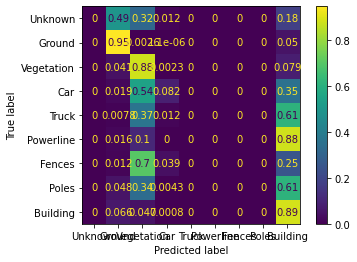

In [99]:
#Using the best hyperparamter to test the result on all class
best_r = 0.2
best_ratio = 0.5

#Get all las file for training 
TILES_SIZE = 15

TRAIN_DIR = f"dales_tiled/tiles_{TILES_SIZE}/train/" 
TEST_DIR = f"dales_tiled/tiles_{TILES_SIZE}/test/" 
all_test_files  = os.listdir(osp.abspath(TEST_DIR))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model(
    sampling_ratio = [best_ratio]*3, 
    ball_radius = [best_r , best_r*2 , best_r*2],
    act = 'relu' ).to(device)
checkpoint = torch.load('models/deep_relu.pt')
model.load_state_dict(checkpoint['model_state_dict'])
cfs, ps, rc ,f1, iou, acc = evaluate(subset = None) 

print(f"Precision {ps}")
print(f"Recall {rc}")
print(f"F1 {f1}")
print(f"IoU {iou}")
print(f"Accuracy {acc}")

In [89]:
from sklearn.metrics import  ConfusionMatrixDisplay

np.save("cfs", cfs)

In [30]:
def c2color(classification):
# Define diffrent color for each class
    color = np.zeros((len(classification), 3))
    color[classification == 0] = [0, 0, 0]
    color[classification == 1] = [0, 0, 1]
    color[classification == 2] = [0, 1, 0]
    color[classification == 3] = [1, 0, 1]
    color[classification == 4] = [1, 1, 0]
    color[classification == 5] = [0, 1, 1]
    color[classification == 6] = [0, 1, 1]
    color[classification == 7] = [1, 0.5, 0]
    color[classification == 8] = [1, 0, 0]
    return color

In [52]:
data = convertData("dales_tiled/tiles_15/train/5080_54435_100.las", transform = False)
pc = lp.read("dales_tiled/tiles_15/train/5080_54435_100.las")

In [55]:
transform = T.Compose([
        T.RandomJitter(0.01),
        T.RandomRotate(15, axis=0),
        T.RandomRotate(15, axis=1),
        T.RandomRotate(15, axis=2)
        ])
pre_transform = T.NormalizeScale()

#make preidciton

data = data.to(device)
ndata = data.clone().detach()
ndata = transform( pre_transform(ndata))

preds  = model(ndata).argmax(dim = -1).detach().cpu().numpy().reshape((-1,1))
labels = data.y.detach().cpu().numpy().reshape((-1,1))
coords  = np.vstack((pc.x, pc.y, pc.z)).T

ncoords = ndata.pos.detach().cpu().numpy()

data_np = np.concatenate([coords, ncoords, labels, preds], axis = 1)
print(data_np.shape)

(10999, 8)


In [56]:
print(np.unique(data_np[:,-1], return_counts = True))

(array([1., 2., 3., 8.]), array([3895, 6669,    1,  434]))


In [57]:
print(data_np[:,:3])

[[5.08048390e+05 5.44359044e+06 1.00430000e+02]
 [5.08048080e+05 5.44359051e+06 1.02980000e+02]
 [5.08047820e+05 5.44359057e+06 1.00330000e+02]
 ...
 [5.08061230e+05 5.44360436e+06 9.60900000e+01]
 [5.08061090e+05 5.44360471e+06 9.46800000e+01]
 [5.08061410e+05 5.44360358e+06 9.45500000e+01]]


In [58]:
np.save("test_sample_1", data_np) 

In [59]:
data = convertData("dales_tiled/tiles_15/test/5080_54400_200.las", transform = False)
pc = lp.read("dales_tiled/tiles_15/test/5080_54400_200.las")

data = data.to(device)
ndata = data.clone().detach()
ndata = transform( pre_transform(ndata))

preds  = model(ndata).argmax(dim = -1).detach().cpu().numpy().reshape((-1,1))
labels = data.y.detach().cpu().numpy().reshape((-1,1))
coords  = np.vstack((pc.x, pc.y, pc.z)).T

ncoords = ndata.pos.detach().cpu().numpy()

data_np = np.concatenate([coords, ncoords, labels, preds], axis = 1)
print(data_np.shape)

(17238, 8)


In [60]:
print(np.unique(data_np[:,-1], return_counts = True))

(array([1., 2., 8.]), array([ 1927, 13367,  1944]))


In [61]:
np.save("test_sample_1", data_np) 